In [1]:
#32 X 32 images of 10 different objects
#Airplane car bird cat deer dog frog horse ship truck
#color images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='../Data',train=True,download=True,transform=transform)

In [4]:
test_data = datasets.CIFAR10(root='../Data',train=False,download=True,transform=transform)

In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [9]:
for images,labels in train_loader:
    break

In [10]:
images[0].shape

torch.Size([3, 32, 32])

In [11]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

Label: [1 5 8 1 6 1 6 3 7 9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


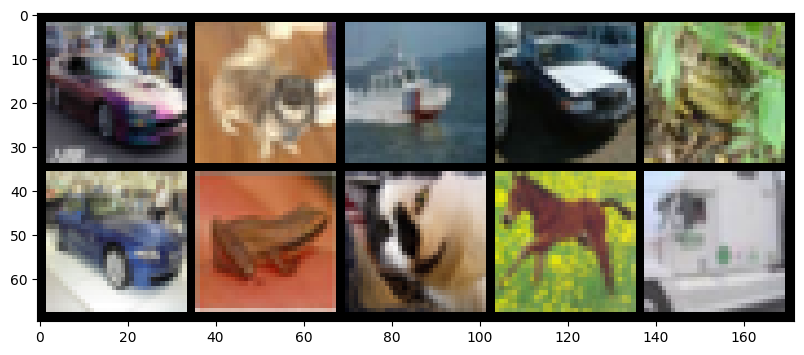

In [12]:
# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))


im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [13]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1) 
        self.conv2 =  nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(6*6*16,120) #(((32-2)/2)-2)/2 = 6.5
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*16*6)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [14]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [17]:
import time
start_time = time.time()
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b,(X_train,y_train) in enumerate(train_loader):
        b += 1 

        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch: 1000 [ 10000/50000]  loss: 2.07518220  accuracy:  26.510%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.83829844  accuracy:  32.540%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 0.97547197  accuracy:  35.947%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.26019025  accuracy:  38.185%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.43481731  accuracy:  40.032%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.27018952  accuracy:  49.330%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.19208932  accuracy:  49.735%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.36482501  accuracy:  50.380%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.82731378  accuracy:  50.737%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.87346530  accuracy:  51.170%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.47868514  accuracy:  55.300%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.55657446  accuracy:  54.960%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.42881167  accuracy:  55.457%
epoch:  2  b

In [19]:
torch.save(model.state_dict(),'myCIFARmodel.pt')

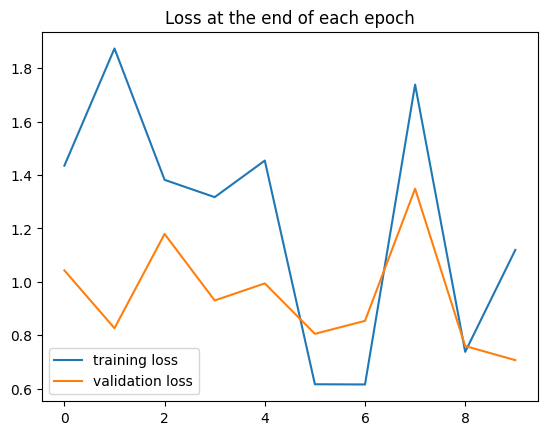

In [20]:
train_losses1 = [t.item() for t in train_losses]
test_losses1 = [t.item() for t in test_losses]
plt.plot(train_losses1,label='training loss')
plt.plot(test_losses1,label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

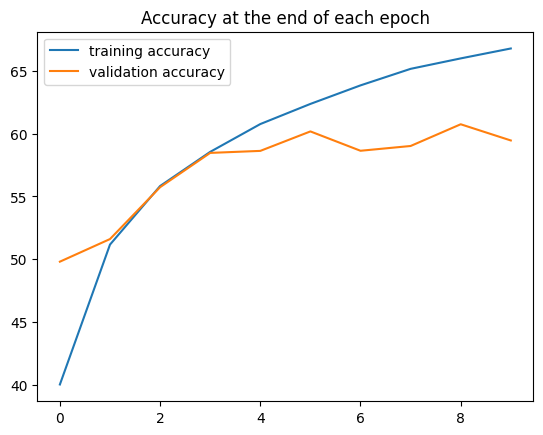

In [21]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [22]:
print(test_correct)

[tensor(4981), tensor(5161), tensor(5574), tensor(5847), tensor(5863), tensor(6018), tensor(5864), tensor(5902), tensor(6075), tensor(5946)]


In [23]:
num_c = test_correct[-1].item()

In [24]:
num_c*100/10000

59.46

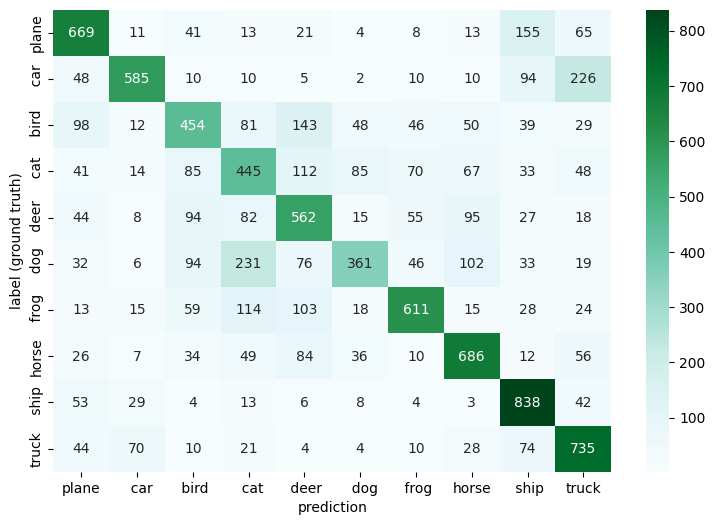

In [25]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [27]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test.view(-1), predicted.view(-1), average='macro')  # or 'weighted'
recall = recall_score(y_test.view(-1), predicted.view(-1), average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.6012
Recall: 0.5946


# Image Reconstruction

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models
import numpy as np
from skimage.metrics import structural_similarity as ssim_metric

In [29]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [30]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:32<00:00, 5.27MB/s]


In [31]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2), nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [32]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:

print("Training...")
for epoch in range(5):
    model.train()
    for img, _ in trainloader:
        noisy_img = img  # or add noise if needed
        output = model(noisy_img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")



Training...
Epoch 1 Loss: 0.0147
Epoch 2 Loss: 0.0090
Epoch 3 Loss: 0.0083
Epoch 4 Loss: 0.0075
Epoch 5 Loss: 0.0074


In [34]:
def psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse.item()))


In [35]:
def ssim(original, reconstructed):
    # Convert tensors to numpy and to grayscale
    original_np = original.squeeze().permute(1, 2, 0).numpy()
    reconstructed_np = reconstructed.squeeze().permute(1, 2, 0).numpy()
    original_gray = np.dot(original_np[..., :3], [0.299, 0.587, 0.114])
    reconstructed_gray = np.dot(reconstructed_np[..., :3], [0.299, 0.587, 0.114])
    return ssim_metric(original_gray, reconstructed_gray, data_range=1.0)



PSNR: 21.06 dB | SSIM: 0.7089


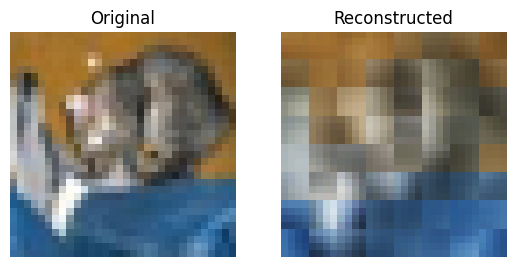

In [41]:
model.eval()
with torch.no_grad():
    for img, _ in testloader:
        reconstructed = model(img)
        p_score = psnr(img, reconstructed)
        s_score = ssim(img[0], reconstructed[0])
        print(f"PSNR: {p_score:.2f} dB | SSIM: {s_score:.4f}")
        
        # Optional: visualize
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(img[0].permute(1, 2, 0)); axs[0].set_title("Original")
        axs[1].imshow(reconstructed[0].permute(1, 2, 0)); axs[1].set_title("Reconstructed")
        for ax in axs: ax.axis('off')
        plt.show()
        break  # Just one image
